In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle as pkl

In [3]:
# Load your dataset (adjust the path if needed)
df = pd.read_csv('all_data.csv')
# Set the Date column as the index
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].sort_values(ascending=False) 
df.set_index('Date', inplace=True)

In [4]:
df.head()

,crude_oil_Price,crude_oil_Open,crude_oil_High,crude_oil_Low,crude_oil_Vol.,crude_oil_Change %,gold_Open,gold_High,gold_Low,gold_Close,...,dollar_rate_High,dollar_rate_Low,dollar_rate_Change %,cpi_CPI,ppi_PPI,is_holiday,gold_price_to_predict,gold_price_yesterday,gold_price_2days,gold_price_3days
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,98.70,98.61,98.76,98.54,NaN,0.28,NaN,NaN,NaN,NaN,...,80.24,80.10,0.00,235.288,203.8,1,118.000000,NaN,NaN,NaN
2014-01-02,95.44,98.50,98.97,95.34,251250.0,-3.30,117.930000,118.730003,117.750000,118.000000,...,80.71,80.08,0.75,235.288,203.8,0,119.290001,NaN,NaN,NaN
2014-01-03,93.96,95.47,95.74,93.86,215520.0,-1.55,118.639999,119.620003,118.589996,119.290001,...,80.89,80.49,0.20,235.288,203.8,0,119.500000,118.000000,NaN,NaN
2014-01-06,93.43,94.18,94.59,93.20,189380.0,-0.56,119.760002,120.389999,117.110001,119.500000,...,80.91,80.54,-0.17,235.288,203.8,0,118.820000,119.290001,118.000000,NaN
2014-01-07,93.67,93.60,94.22,93.35,177180.0,0.26,118.459999,118.919998,118.129997,118.820000,...,80.95,80.60,0.22,235.288,203.8,0,118.120003,119.500000,119.290001,118.0


In [5]:
gold_prices = df['gold_Close'].copy().dropna()  # Drop missing values

Checking the stationarity of the difference - we need this for choosing the d parameter of the ARIMA model

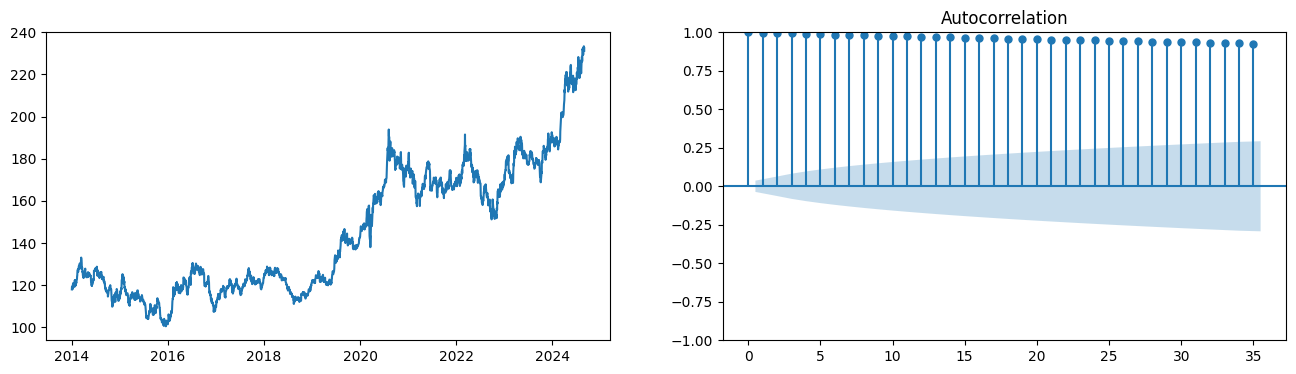

In [6]:
# Regular Prices
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(gold_prices)
plot_acf(gold_prices, ax=ax2);

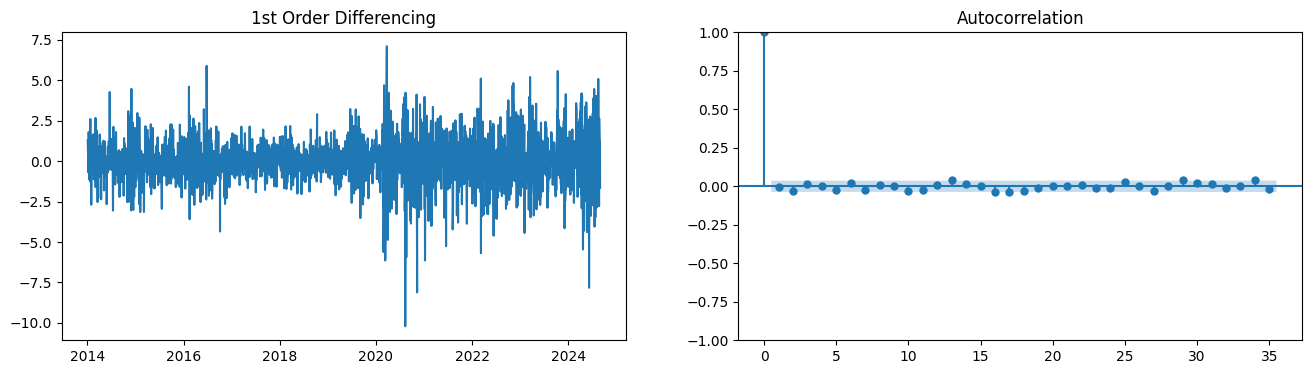

In [7]:
# Difference of the prices (1 day)
from statsmodels.tsa.stattools import adfuller
diff = gold_prices.diff().dropna()
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('1st Order Differencing')
plot_acf(diff, ax=ax2);

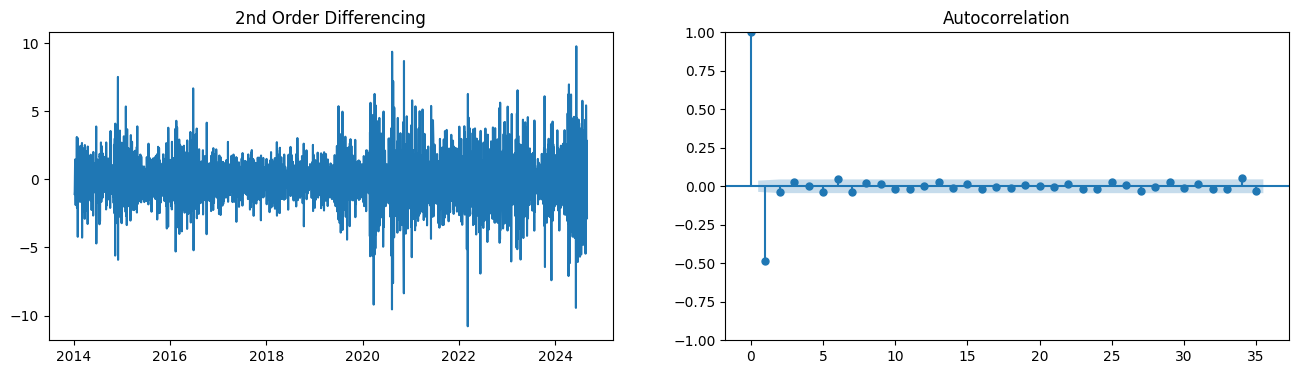

In [8]:
# Difference of the prices (2 days)
diff2 = gold_prices.diff().diff().dropna()
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff2)
ax1.set_title('2nd Order Differencing')
plot_acf(diff2, ax=ax2);

In [15]:
import pmdarima
from pmdarima.arima.utils import ndiffs
ndiffs(gold_prices, test='adf')

ModuleNotFoundError: No module named 'pmdarima'

In [10]:
!pip install pmdarima

In [1]:
# Use only the gold_Price column for the ARIMA model

# Split the data into training and testing sets
train_size = int(len(gold_prices) * 0.8)  # 80% training, 20% testing
train_data, test_data = gold_prices[:train_size], gold_prices[train_size:]

# Define and fit the ARIMA model (p, d, q)
# p=4 - looking 4 days back
# d=1 - using the differences (?)
# q=2 - using 2 last errors (?)
model = ARIMA(train_data, order=(4, 1, 2)) 
model_fit = model.fit()
# Print the model summary
print(model_fit.summary())

# Forecasting one day ahead using the true data each time
history = list(train_data)  # Create a list from the training data
predictions = []

for t in range(len(test_data)):
    #print(t)
    yhat = model_fit.forecast(steps=1)
    predictions.append(yhat)
    #history.append(test_data.iloc[t])
    model_fit = model_fit.append([test_data.iloc[t]])
    #model_fit = model_fit.append([yhat])

# Convert predictions to a list of numbers
predictions = [float(pred) for pred in predictions]

# Convert predictions to a DataFrame for easier plotting
pred_index = gold_prices.index[train_size:]  # Create an index for predictions
arima_predictions_df = pd.DataFrame(predictions, index=pred_index, columns=['Predictions'])

# Combine predictions and actual test data
test_data = test_data.to_frame()
arima_predictions_df = test_data.join(arima_predictions_df)
#print(arima_predictions_df)
# Plotting the results
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Training Data')
plt.plot(arima_predictions_df.index, arima_predictions_df['gold_Close'], color='blue', label='Actual Gold Price')
plt.plot(arima_predictions_df.index, arima_predictions_df['Predictions'], color='red', linestyle='--', label='Predicted Gold Price')
plt.title('Gold Price Prediction')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(arima_predictions_df['gold_Close'], arima_predictions_df['Predictions']))
mae = mean_absolute_error(arima_predictions_df['gold_Close'], arima_predictions_df['Predictions'])

print(f"Root Mean Square Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

NameError: name 'gold_prices' is not defined

In [50]:
with open('modelResults/arima_predictions_df', 'wb') as file:
    # Serialize the object and write it to the file
    pkl.dump(arima_predictions_df, file)

            gold_Close  ARIMA_Predictions  gold_price_to_predict   
Date                                                               
2022-07-21  160.270004         158.072802                    NaN  \
2022-07-22  160.669998         160.372835             160.669998   
2022-07-23         NaN                NaN             160.229996   
2022-07-25  160.229996         160.624256                    NaN   
2022-07-26  160.039993         160.258148             160.039993   
...                ...                ...                    ...   
2024-08-26  232.759995         232.018679                    NaN   
2024-08-27  233.389999         232.644301             233.389999   
2024-08-28  231.750000         233.445277             231.750000   
2024-08-29  232.949997         231.721656             232.949997   
2024-08-30  231.289993         232.969671             231.289993   

            Linear_Reg_Predictions  
Date                                
2022-07-21                     NaN  
2022

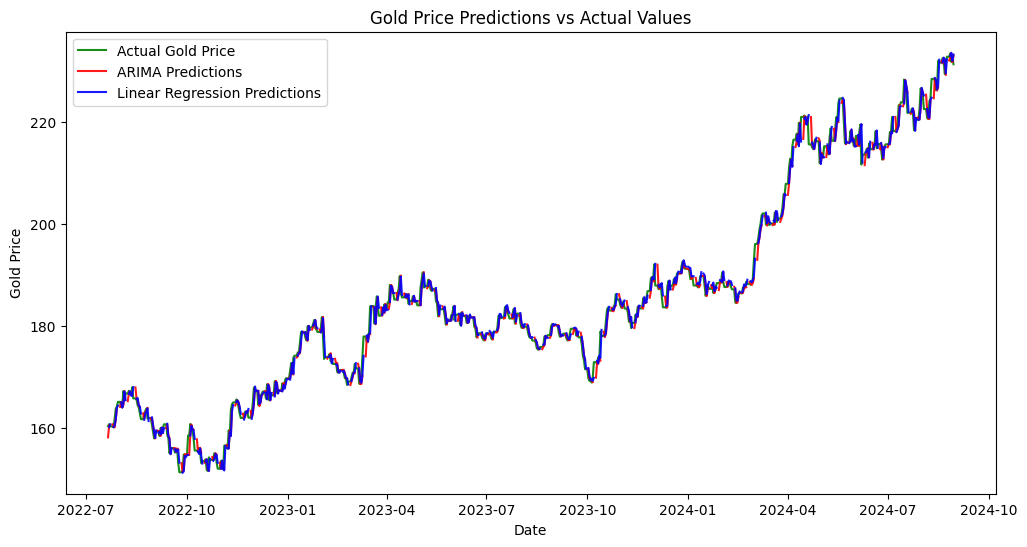